In [2]:
import warnings # Ignorar todos los warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from functions_3 import load_and_clean_data, save_clean_data
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from joblib import dump
import logging

# Configuración básica del logging
logging.basicConfig(
    filename='model/model_log.txt',  # Archivo donde se guardará el log
    level=logging.INFO,         # Nivel de logging (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s'  # Formato del log
)

logging.info("Inicio del modelo")

# Configurar Pandas para mostrar todos los resultados
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# 1. Cargar y limpiar los datos
df = load_and_clean_data('data/raw/owid-energy-data.csv')

# Guardar el dataframe limpio en un archivo CSV
save_clean_data(df, 'data/clean/cleaned_data.csv')

# Imprimir un resumen estadístico
print("Resumen estadístico:")
print(df.describe())

Resumen estadístico:
               year       country      iso_code    population           gdp  \
count  21812.000000  2.181200e+04  2.181200e+04  21812.000000  2.181200e+04   
mean    1974.195718  1.667880e-16  1.667880e-16      0.000000  1.042425e-17   
std       35.342860  1.000023e+00  1.000023e+00      1.000023  1.000023e+00   
min     1900.000000 -1.694203e+00 -1.785087e+00     -0.245677 -1.652175e-01   
25%     1946.000000 -8.932250e-01 -9.105355e-01     -0.239639 -1.507380e-01   
50%     1984.000000  6.194821e-04  1.389259e-01     -0.221922  2.367735e-17   
75%     2004.000000  8.480305e-01  1.107660e+00     -0.012264  2.367735e-17   
max     2023.000000  1.707050e+00  1.174933e+00     18.506549  5.030924e+01   

       electricity_demand  electricity_generation  electricity_share_energy  \
count        2.181200e+04            2.181200e+04              2.181200e+04   
mean         5.212123e-18           -2.736365e-17             -2.353274e-15   
std          1.000023e+00     

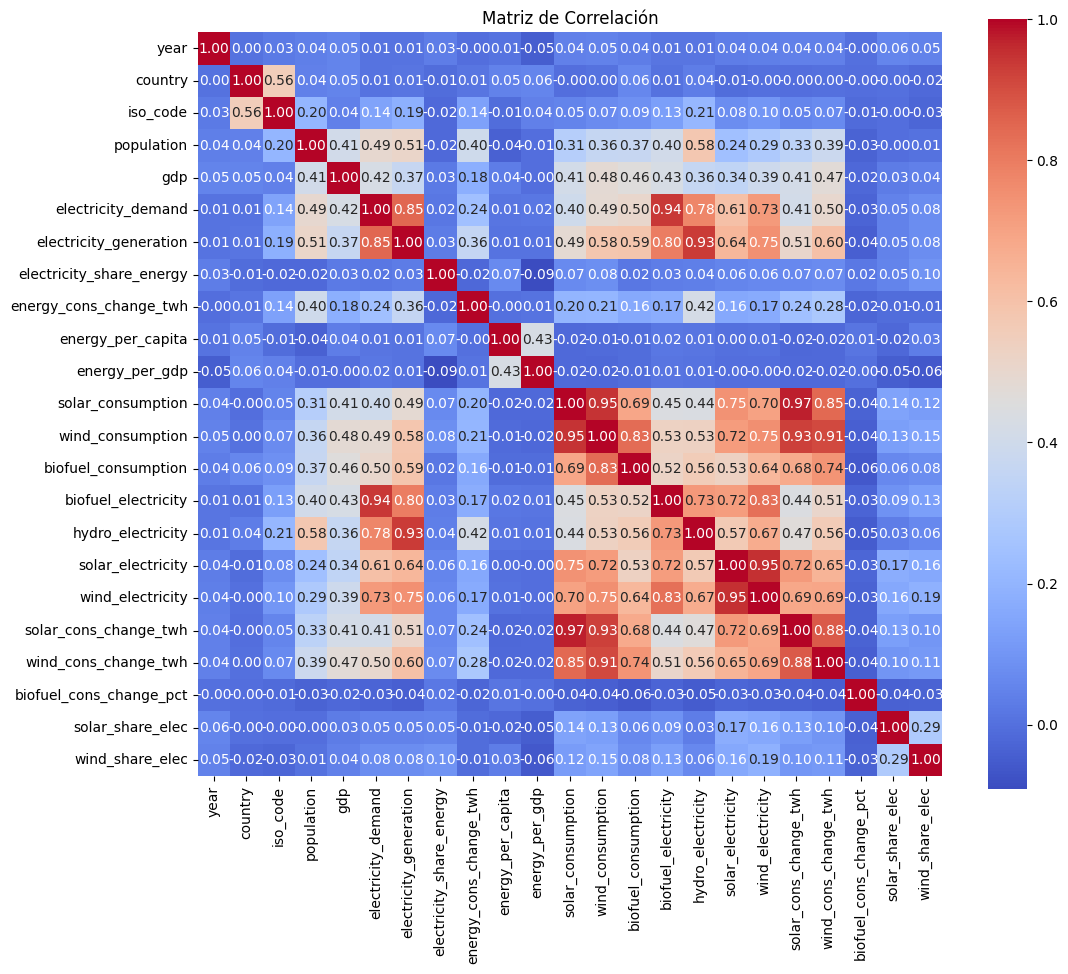

In [4]:
#2. Matriz de correlación
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')
plt.show()

In [5]:
# 3. Separar características y variables objetivo
target_columns = ['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']
X = df.drop(columns=target_columns)
y = df[target_columns]

In [6]:
# 4. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# 5. Definir el modelo
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))


In [8]:
# 6. Entrenar el modelo
model.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [9]:
# 7. Realizar predicciones
y_pred = pd.DataFrame(model.predict(X_test), columns=target_columns)

# Mostrar las predicciones completas
print("Predicciones completas:")
print(y_pred)

Predicciones completas:
      solar_electricity  wind_electricity  hydro_electricity  \
0         -4.727270e-17          0.000000      -5.899983e-17   
1         -4.727270e-17          0.000000      -5.899983e-17   
2         -4.727270e-17          0.000000      -5.899983e-17   
3         -4.727270e-17          0.000000      -4.178558e-01   
4         -2.181491e-01         -0.273044      -4.709563e-01   
5         -2.181491e-01         -0.278477      -5.001555e-01   
6         -2.181491e-01         -0.278477      -4.972321e-01   
7         -4.727270e-17          0.000000      -5.899983e-17   
8         -4.727270e-17          0.000000      -5.899983e-17   
9         -2.181491e-01         -0.278477      -4.764110e-01   
10        -2.181491e-01         -0.278477      -4.352992e-01   
11        -4.727270e-17          0.000000      -5.899983e-17   
12        -4.727270e-17          0.000000      -5.899983e-17   
13        -2.168539e-01         -0.125946      -4.711234e-01   
14        -4.727

In [10]:
# 8. Calcular métricas de rendimiento
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

MAE: 0.01, RMSE: 0.12, R²: 0.99


In [11]:
# 9. Ajustar el GridSearch para pruebas más rápidas
param_grid = {
    'estimator__n_estimators': [50, 100],  # Reducido para acelerar
    'estimator__max_depth': [None, 10],
    'estimator__min_samples_split': [2]
}

grid_search = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print(f"MAE (Mejor Modelo): {-grid_search.best_score_:.4f}")


Mejores parámetros: {'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100}
MAE (Mejor Modelo): 0.0145


In [12]:
# 10. Guardar el modelo
dump(grid_search, 'model/energy_model_seap.joblib')

# Guardar los nombres de las características usadas durante el entrenamiento
features = X_train.columns.tolist()  # Obtener las columnas del conjunto de entrenamiento
dump(features, 'model/energy_model_features.joblib')  # Guardar las características
# Guardar las columnas utilizadas para el modelo
features_filepath = 'model/energy_model_features_columns.txt'
with open(features_filepath, 'w') as f:
    for column in X.columns:
        f.write(f"{column}\n")

logging.info("Modelo guardado.")

In [13]:
# 11. Validación cruzada
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"MAE (Validación Cruzada): {-cv_scores.mean():.4f}")


MAE (Validación Cruzada): 0.0535


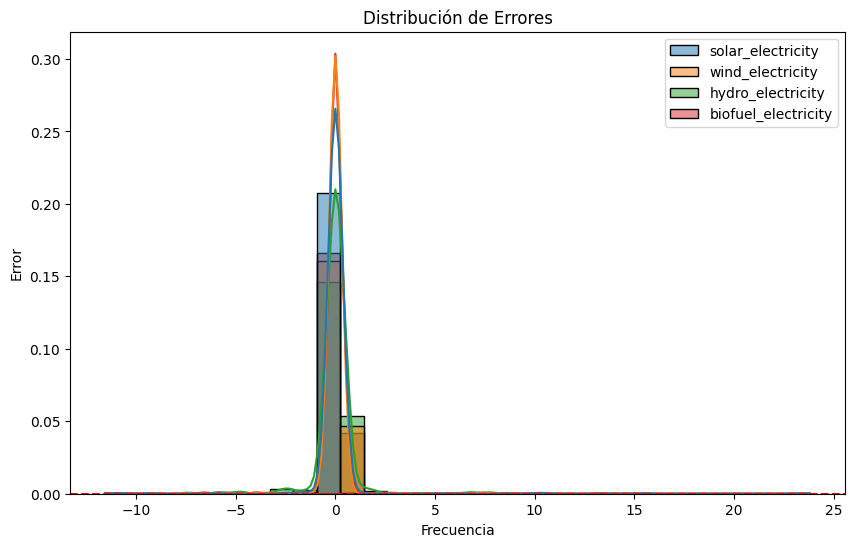

In [14]:
# 12. Analizar la distribución de errores

# Calcular los errores
errors = y_test - y_pred

# Crear la gráfica con errores en el eje Y
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30, stat='density', color='blue')  # Agrega 'stat' para densidad
plt.title('Distribución de Errores')
plt.ylabel('Error')  # Cambiar el eje Y a "Error"
plt.xlabel('Frecuencia')  # Cambiar el eje X a "Frecuencia"
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en 0 para referencia
plt.show()


Top 10 características más importantes:
                        Importance
solar_consumption         0.345799
electricity_generation    0.201314
electricity_demand        0.139954
solar_share_elec          0.124544
solar_cons_change_twh     0.064185
year                      0.057440
wind_share_elec           0.025566
wind_cons_change_twh      0.009138
population                0.007715
wind_consumption          0.007667


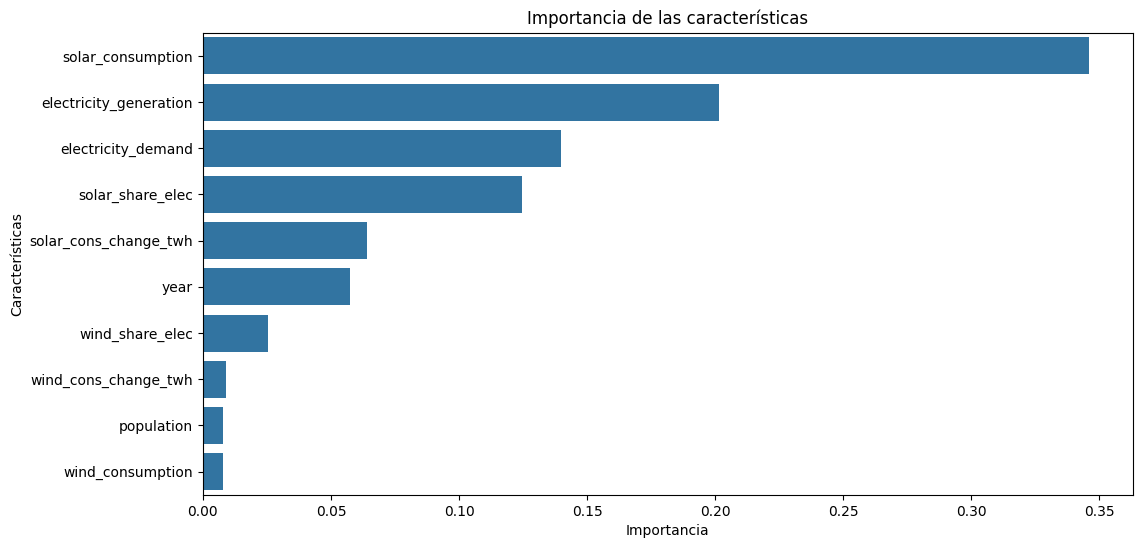

In [15]:
# 13. Importancia de las características
importances = model.estimators_[0].feature_importances_
feature_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"]).sort_values("Importance", ascending=False)

# Mostrar las 10 características más importantes
print("Top 10 características más importantes:")
print(feature_importances.head(10))

# Graficar la importancia de las características
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances["Importance"].head(10), y=feature_importances.index[:10])
plt.title("Importancia de las características")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()



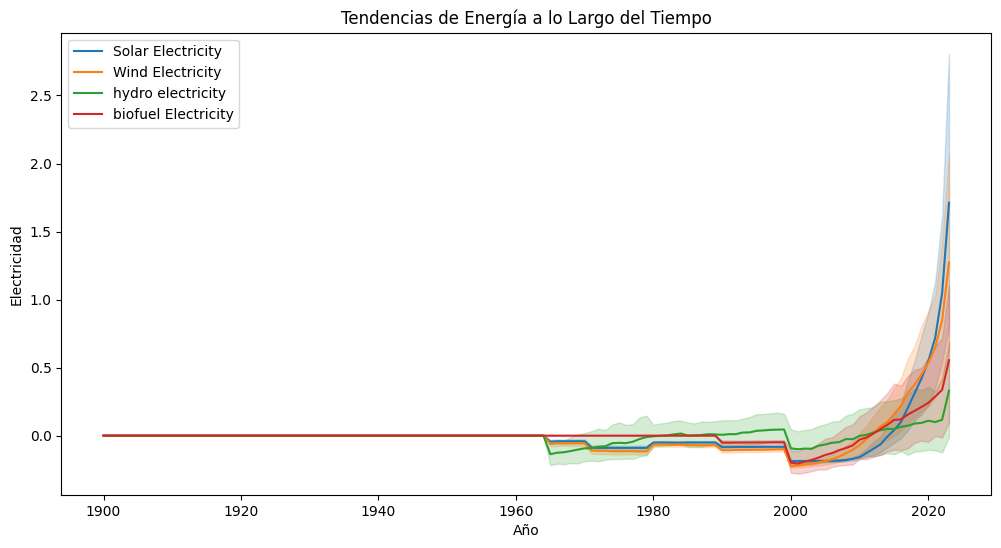

In [16]:
# 14. Tendencias de energía a lo largo del tiempo
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='year', y='solar_electricity', label='Solar Electricity')
sns.lineplot(data=df, x='year', y='wind_electricity', label='Wind Electricity')
sns.lineplot(data=df, x='year', y='hydro_electricity', label='hydro electricity')
sns.lineplot(data=df, x='year', y='biofuel_electricity', label='biofuel Electricity')
plt.title('Tendencias de Energía a lo Largo del Tiempo')
plt.xlabel('Año')
plt.ylabel('Electricidad')
plt.legend()
plt.show()


In [17]:
columns_of_interest = [
    'year', 'country', 'iso_code', 'population', 'gdp', 
    'electricity_demand', 'electricity_generation', 'electricity_share_energy',
    'energy_cons_change_twh', 'energy_per_capita', 'energy_per_gdp', 
    'solar_consumption', 'wind_consumption', 'biofuel_consumption', 
    'solar_cons_change_twh', 'wind_cons_change_twh', 
    'biofuel_cons_change_pct', 'solar_share_elec', 'wind_share_elec'
]

# Filtrar el DataFrame
filtered_data = df[columns_of_interest]

# Obtener estadísticas descriptivas
statistics = filtered_data.describe()

# Mostrar las estadísticas
display(statistics)

year       country      iso_code    population           gdp  \
count  21812.000000  2.181200e+04  2.181200e+04  21812.000000  2.181200e+04   
mean    1974.195718  1.667880e-16  1.667880e-16      0.000000  1.042425e-17   
std       35.342860  1.000023e+00  1.000023e+00      1.000023  1.000023e+00   
min     1900.000000 -1.694203e+00 -1.785087e+00     -0.245677 -1.652175e-01   
25%     1946.000000 -8.932250e-01 -9.105355e-01     -0.239639 -1.507380e-01   
50%     1984.000000  6.194821e-04  1.389259e-01     -0.221922  2.367735e-17   
75%     2004.000000  8.480305e-01  1.107660e+00     -0.012264  2.367735e-17   
max     2023.000000  1.707050e+00  1.174933e+00     18.506549  5.030924e+01   

       electricity_demand  electricity_generation  electricity_share_energy  \
count        2.181200e+04            2.181200e+04              2.181200e+04   
mean         5.212123e-18           -2.736365e-17             -2.353274e-15   
std          1.000023e+00            1.000023e+00              1.000023e+00   
min         -4.764398e-01           -5.160525e-01             -4.999462e+00   
25%          0.000000e+00           -4.279481e-01             -2.357949e-15   
50%          0.000000e+00            0.000000e+00             -2.357949e-15   
75%          0.000000e+00            0.000000e+00             -2.357949e-15   
max          2.245692e+01            1.897502e+01              1.755186e+01   

       energy_cons_change_twh  energy_per_capita  energy_per_gdp  \
count            2.181200e+04       2.181200e+04    2.181200e+04   
mean            -3.648486e-17       2.606062e-17   -1.824243e-16   
std              1.000023e+00       1.000023e+00    1.000023e+00   
min             -1.726933e+01      -1.021663e+00   -1.654604e+00   
25%             -2.446863e-01      -4.512915e-01   -2.155751e-16   
50%             -3.986040e-17       0.000000e+00   -2.155751e-16   
75%             -3.986040e-17       0.000000e+00   -2.155751e-16   
max              2.473716e+01       2.493844e+01    2.278690e+01   

       solar_consumption  wind_consumption  biofuel_consumption  \
count       2.181200e+04      2.181200e+04         2.181200e+04   
mean        3.387880e-17      3.387880e-17         1.042425e-17   
std         1.000023e+00      1.000023e+00         1.000023e+00   
min        -3.257229e-01     -4.164785e-01        -9.255567e-01   
25%         4.364677e-17      4.927148e-17         0.000000e+00   
50%         4.364677e-17      4.927148e-17         0.000000e+00   
75%         4.364677e-17      4.927148e-17         0.000000e+00   
max         5.206275e+01      4.146945e+01         3.027859e+01   

       solar_cons_change_twh  wind_cons_change_twh  biofuel_cons_change_pct  \
count           2.181200e+04          2.181200e+04             2.181200e+04   
mean           -4.039396e-17          2.215152e-17             8.380117e-17   
std             1.000023e+00          1.000023e+00             1.000023e+00   
min            -6.416152e-01         -3.164578e+00            -1.900404e+00   
25%            -5.418733e-17          4.786990e-17             9.281192e-17   
50%            -5.418733e-17          4.786990e-17             9.281192e-17   
75%            -5.418733e-17          4.786990e-17             9.281192e-17   
max             4.955664e+01          3.610743e+01             7.332861e+01   

       solar_share_elec  wind_share_elec  
count      2.181200e+04     2.181200e+04  
mean       4.560608e-17     6.775761e-17  
std        1.000023e+00     1.000023e+00  
min       -5.398093e-01    -5.540919e-01  
25%       -4.168824e-01    -3.651544e-01  
50%        7.754329e-17     8.246201e-17  
75%        7.754329e-17     8.246201e-17  
max        3.438258e+01     2.088024e+01

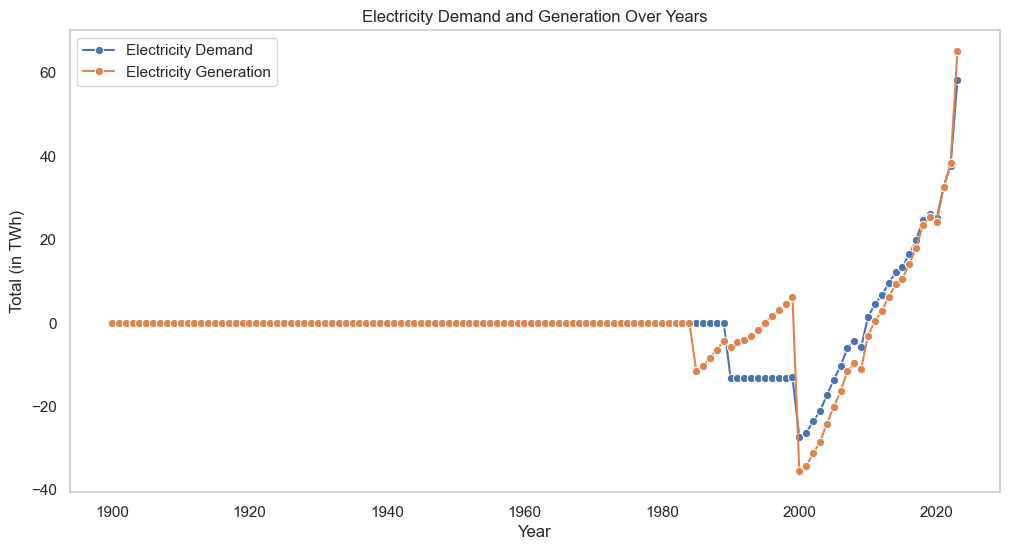

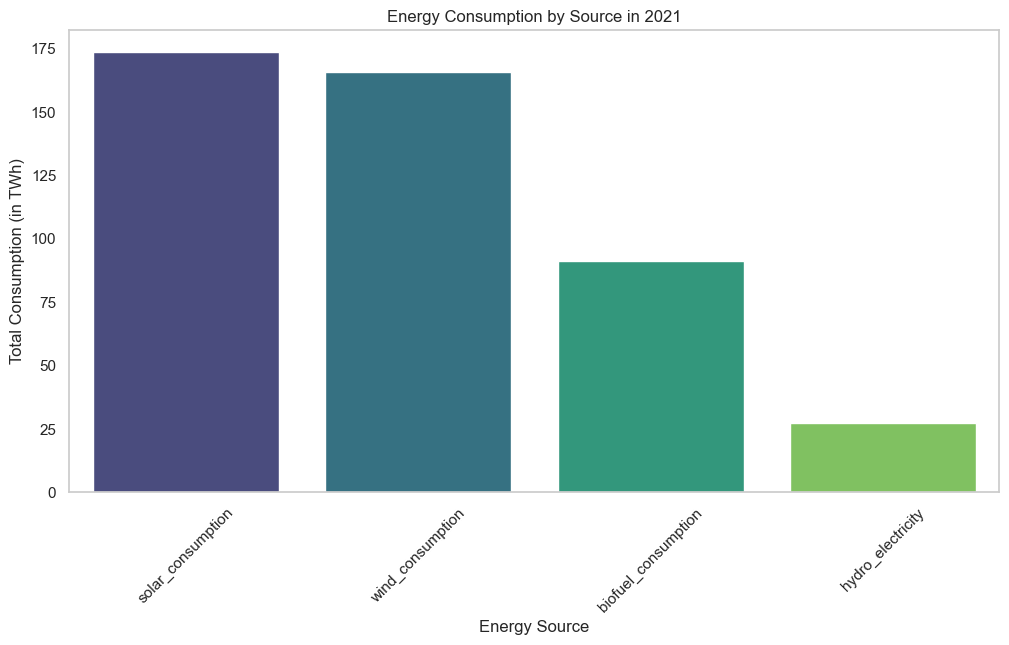

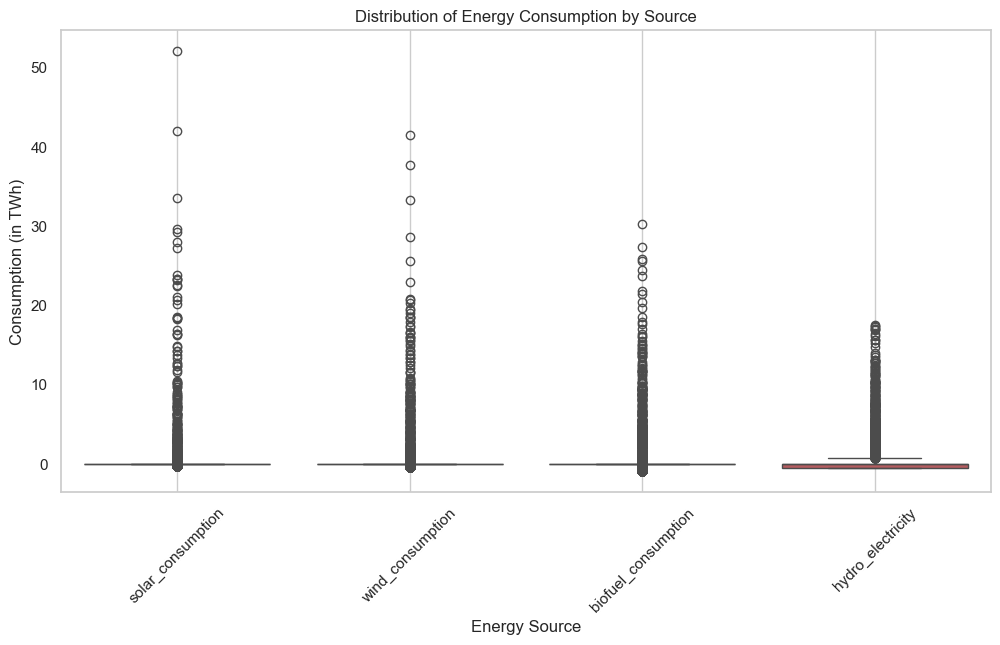

In [18]:
# Cargar los datos
data = pd.read_csv('data/clean/cleaned_data.csv')

# Establecer el estilo de seaborn
sns.set(style='whitegrid')

# 1. Gráfico de Barras de la Demanda y Generación de Electricidad por Año
filtered_data = data[['year', 'electricity_demand', 'electricity_generation']]
yearly_data = filtered_data.groupby('year').sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_data, x='year', y='electricity_demand', label='Electricity Demand', marker='o')
sns.lineplot(data=yearly_data, x='year', y='electricity_generation', label='Electricity Generation', marker='o')
plt.title('Electricity Demand and Generation Over Years')
plt.xlabel('Year')
plt.ylabel('Total (in TWh)')
plt.legend()
plt.grid()
plt.show()


# 3. Gráfico de Barras de Consumo de Energía por Tipo para el año 2021
specific_year_data = data[data['year'] == 2021]
energy_sources = ['solar_consumption', 'wind_consumption', 'biofuel_consumption', 'hydro_electricity']
consumption_data = specific_year_data[energy_sources].sum().reset_index()
consumption_data.columns = ['Energy Source', 'Total Consumption (TWh)']

plt.figure(figsize=(12, 6))
sns.barplot(data=consumption_data, x='Energy Source', y='Total Consumption (TWh)', palette='viridis')
plt.title('Energy Consumption by Source in 2021')
plt.xlabel('Energy Source')
plt.ylabel('Total Consumption (in TWh)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# 4. Gráfico de Caja de Consumo de Energía por Fuente
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[energy_sources])
plt.title('Distribution of Energy Consumption by Source')
plt.xlabel('Energy Source')
plt.ylabel('Consumption (in TWh)')
plt.xticks(rotation=45)
plt.grid()
plt.show()


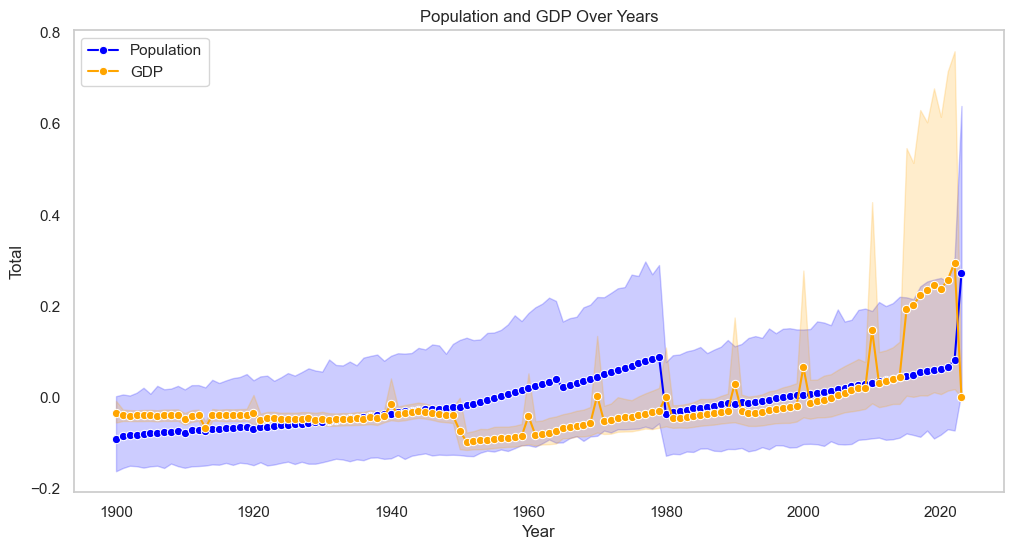

In [19]:
# Establecer el estilo de seaborn
sns.set(style='whitegrid')

# 1. Gráfico de Línea de Población y PIB a lo Largo de los Años
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='year', y='population', label='Population', color='blue', marker='o')
sns.lineplot(data=data, x='year', y='gdp', label='GDP', color='orange', marker='o')
plt.title('Population and GDP Over Years')
plt.xlabel('Year')
plt.ylabel('Total')
plt.legend()
plt.grid()
plt.show()


In [21]:
import geopandas as gpd

# Cargar el archivo Shapefile
world = gpd.read_file('shapefiles/ne_110m_admin_0_countries.shp')

pd.set_option('display.max_rows', None)  # Mostrar todas las filas
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# Mostrar el DataFrame entero
display(world)

featurecla  scalerank  LABELRANK                        SOVEREIGNT  \
0    Admin-0 country          1          6                              Fiji   
1    Admin-0 country          1          3       United Republic of Tanzania   
2    Admin-0 country          1          7                    Western Sahara   
3    Admin-0 country          1          2                            Canada   
4    Admin-0 country          1          2          United States of America   
5    Admin-0 country          1          3                        Kazakhstan   
6    Admin-0 country          1          3                        Uzbekistan   
7    Admin-0 country          1          2                  Papua New Guinea   
8    Admin-0 country          1          2                         Indonesia   
9    Admin-0 country          1          2                         Argentina   
10   Admin-0 country          1          2                             Chile   
11   Admin-0 country          1          2  Democratic Republic of the Congo   
12   Admin-0 country          1          6                           Somalia   
13   Admin-0 country          1          2                             Kenya   
14   Admin-0 country          1          3                             Sudan   
15   Admin-0 country          1          3                              Chad   
16   Admin-0 country          1          5                             Haiti   
17   Admin-0 country          1          5                Dominican Republic   
18   Admin-0 country          1          2                            Russia   
19   Admin-0 country          1          4                       The Bahamas   
20   Admin-0 country          1          5                    United Kingdom   
21   Admin-0 country          1          3                            Norway   
22   Admin-0 country          1          3                           Denmark   
23   Admin-0 country          3          6                            France   
24   Admin-0 country          1          5                        East Timor   
25   Admin-0 country          1          2                      South Africa   
26   Admin-0 country          1          6                           Lesotho   
27   Admin-0 country          1          2                            Mexico   
28   Admin-0 country          1          4                           Uruguay   
29   Admin-0 country          1          2                            Brazil   
30   Admin-0 country          1          3                           Bolivia   
31   Admin-0 country          1          2                              Peru   
32   Admin-0 country          1          2                          Colombia   
33   Admin-0 country          1          4                            Panama   
34   Admin-0 country          1          5                        Costa Rica   
35   Admin-0 country          1          5                         Nicaragua   
36   Admin-0 country          1          5                          Honduras   
37   Admin-0 country          1          6                       El Salvador   
38   Admin-0 country          1          3                         Guatemala   
39   Admin-0 country          1          6                            Belize   
40   Admin-0 country          1          3                         Venezuela   
41   Admin-0 country          1          4                            Guyana   
42   Admin-0 country          1          4                          Suriname   
43   Admin-0 country          1          2                            France   
44   Admin-0 country          1          3                           Ecuador   
45   Admin-0 country          1          5          United States of America   
46   Admin-0 country          1          4                           Jamaica   
47   Admin-0 country          1          3                              Cuba   
48   Admin-0 country          1          3                          Zimbabwe   
49   Admin

In [22]:
import folium
import pandas as pd
import geopandas as gpd

# Agrupar y preparar los datos para el mapa
data_map = data[['country', 'iso_code', 'electricity_demand']].groupby('country').mean().reset_index()

# Convertir la columna 'country' a string
data_map['country'] = data_map['country'].astype(str)

# Cargar el archivo Shapefile de Natural Earth (asegúrate de que apunte a la ruta correcta)
world = gpd.read_file('shapefiles/ne_110m_admin_0_countries.shp')

# Hacer merge de los datos de electricidad con el mapa mundial utilizando la columna 'NAME'
world = world.merge(data_map, left_on='NAME', right_on='country', how='left')

# Rellenar los valores NaN en 'electricity_demand' con 0 (o lo que consideres apropiado)
world['electricity_demand'].fillna(0, inplace=True)

# Crear un mapa base centrado en un punto (latitud y longitud) usando Folium
m = folium.Map(location=[0, 0], zoom_start=2)

# Crear un GeoDataFrame con las geometrías y datos de los países para usar con Folium
geo_data = world[['geometry', 'NAME', 'electricity_demand']].dropna()

# Convertir el GeoDataFrame a JSON para que Folium pueda interpretarlo
geo_json = geo_data.to_json()

# Añadir la capa de coropletas (choropleth) al mapa
folium.Choropleth(
    geo_data=geo_json,
    data=world,  # Data para el mapa
    columns=['NAME', 'electricity_demand'],  # Columnas usadas para el shading
    key_on='feature.properties.NAME',  # Vinculación entre el JSON y los datos
    fill_color='OrRd',  # Esquema de color
    fill_opacity=0.7,  # Opacidad de los colores
    line_opacity=0.2,
    legend_name='Demanda Eléctrica por País'
).add_to(m)

# Mostrar el mapa
m.save("mapa_demanda_electrica.html")
m




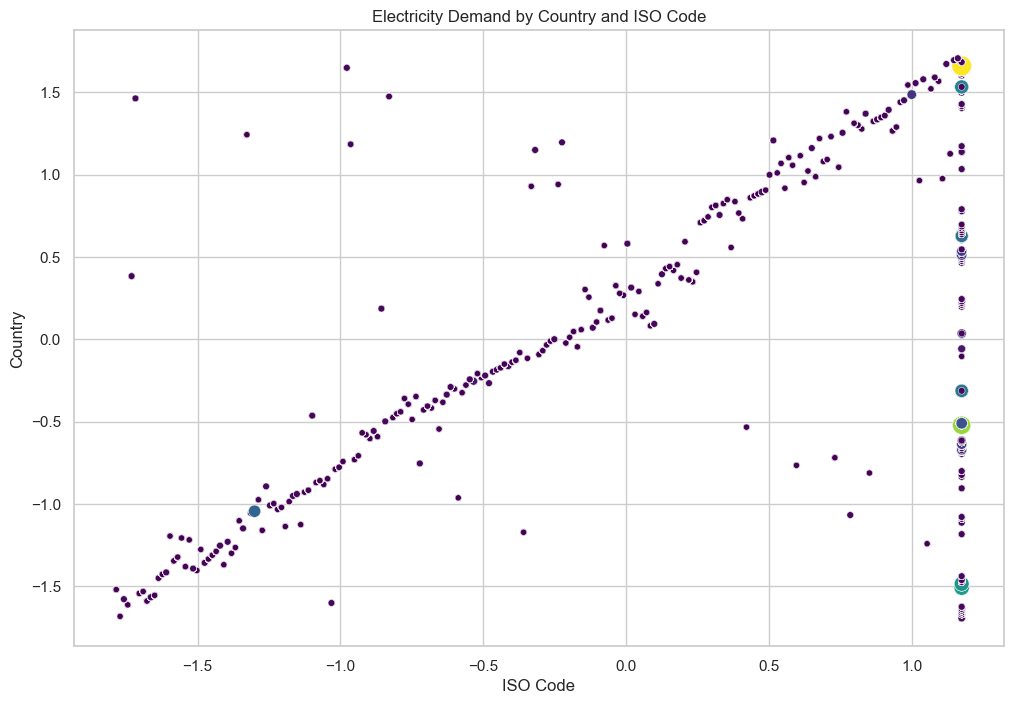

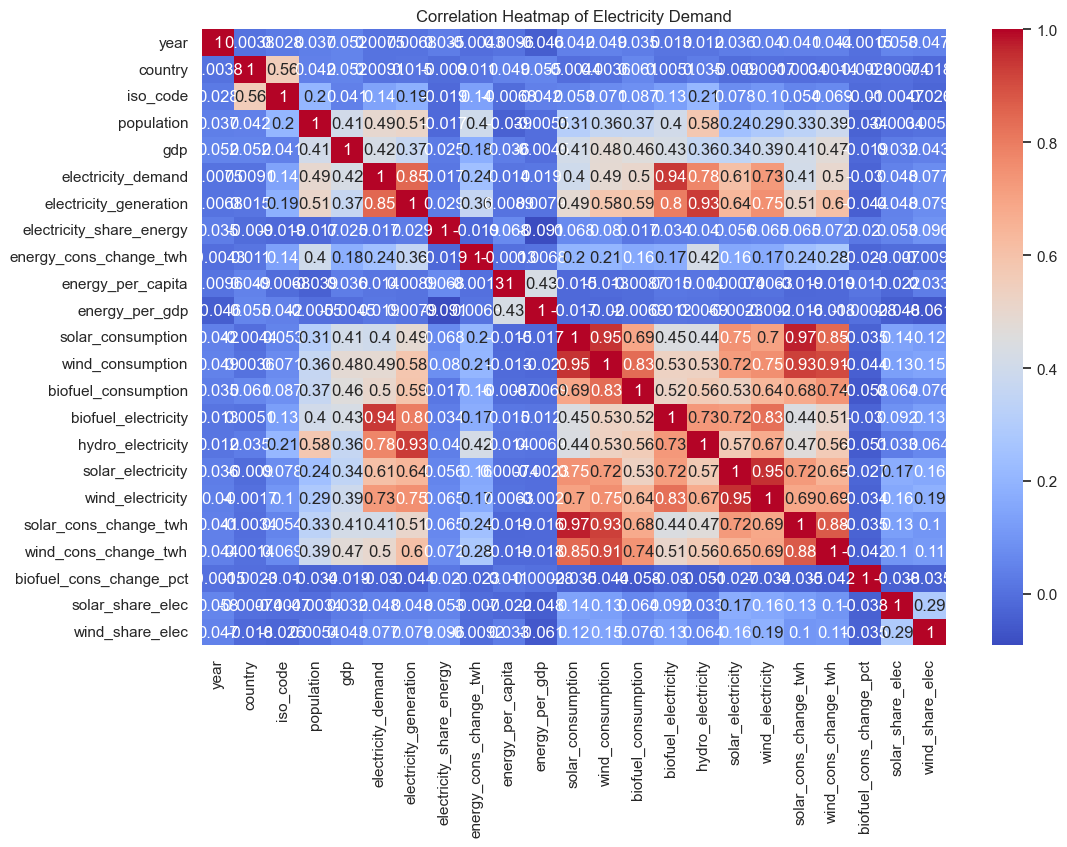

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Establece la figura
plt.figure(figsize=(12, 8))

# Crea el scatterplot
sns.scatterplot(
    data=df, 
    x='iso_code', 
    y='country', 
    hue='electricity_demand',  # Cambia 'country' por 'electricity_demand'
    palette='viridis',  # Cambia la paleta si es necesario
    size='electricity_demand',  # Opcional: usa tamaño basado en 'electricity_demand'
    sizes=(20, 200),  # Ajusta los tamaños de los puntos
    legend=None
)

# Añade etiquetas y título
plt.xlabel('ISO Code')
plt.ylabel('Country')
plt.title('Electricity Demand by Country and ISO Code')
plt.show()


import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que 'corr_matrix' es tu matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Electricity Demand')
plt.show()


In [24]:
import pandas as pd

# Supongamos que 'df' es tu DataFrame con los datos
# Calcula la matriz de correlación
corr_matrix = df.corr()

# Imprime la matriz de correlación
print("Correlation Matrix:")
print(corr_matrix)

# Si deseas imprimir solo un conjunto específico de correlaciones, por ejemplo, con respecto a 'electricity_demand'
print("\nCorrelations with Electricity Demand:")
print(corr_matrix['electricity_demand'].sort_values(ascending=False))


Correlation Matrix:
                              year   country  iso_code  population       gdp  \
year                      1.000000  0.003850  0.027914    0.037316  0.051916   
country                   0.003850  1.000000  0.555432    0.042099  0.052282   
iso_code                  0.027914  0.555432  1.000000    0.203308  0.041490   
population                0.037316  0.042099  0.203308    1.000000  0.407103   
gdp                       0.051916  0.052282  0.041490    0.407103  1.000000   
electricity_demand        0.007526  0.009088  0.140974    0.493145  0.424785   
electricity_generation    0.006841  0.014776  0.185274    0.511943  0.368865   
electricity_share_energy  0.034550 -0.009025 -0.018536   -0.016720  0.025110   
energy_cons_change_twh   -0.004321  0.011232  0.137189    0.397469  0.178332   
energy_per_capita         0.009573  0.049264 -0.006834   -0.038513  0.036491   
energy_per_gdp           -0.046148  0.055063  0.041598   -0.005491 -0.004541   
solar_consumption   

In [25]:
# Agrupar y preparar los datos para el mapa
data_map = data[['country', 'iso_code', 'electricity_demand']].groupby('country').mean().reset_index()

# Imprimir el DataFrame agrupado
print("Data Map (Agrupado):")
print(data_map)

# Comprobar los datos originales
print("Datos Originales:")
print(data[['country', 'electricity_demand']].head())  # Muestra las primeras filas de interés

# Convertir la columna 'country' a string
data_map['country'] = data_map['country'].astype(str)

# Cargar el archivo Shapefile de Natural Earth
world = gpd.read_file('shapefiles/ne_110m_admin_0_countries.shp')

# Hacer merge de los datos de electricidad con el mapa mundial utilizando la columna 'NAME'
world = world.merge(data_map, left_on='NAME', right_on='country', how='left')

# Comprobar el resultado del merge
print("Resultado del Merge:")
print(world[['NAME', 'electricity_demand']].head())

# Rellenar los valores NaN en 'electricity_demand' con 0
world['electricity_demand'].fillna(0, inplace=True)

# Crear un mapa base centrado en un punto (latitud y longitud) usando Folium
m = folium.Map(location=[0, 0], zoom_start=2)

# Crear un GeoDataFrame con las geometrías y datos de los países para usar con Folium
geo_data = world[['geometry', 'NAME', 'electricity_demand']].dropna()

# Convertir el GeoDataFrame a JSON para que Folium pueda interpretarlo
geo_json = geo_data.to_json()

# Añadir la capa de coropletas (choropleth) al mapa
folium.Choropleth(
    geo_data=geo_json,
    data=world,  # Data para el mapa
    columns=['NAME', 'electricity_demand'],  # Columnas usadas para el shading
    key_on='feature.properties.NAME',  # Vinculación entre el JSON y los datos
    fill_color='YlGn',  # Esquema de color
    fill_opacity=0.7,  # Opacidad de los colores
    line_opacity=0.2,
    legend_name='Demanda Eléctrica por País'
).add_to(m)

# Añadir marcadores para destacar los países con la mayor demanda
for _, row in world.iterrows():
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        popup=f"{row['NAME']}: {row['electricity_demand']:.2f}",
        icon=None
    ).add_to(m)

# Mostrar el mapa
m.save("mapa_demanda_electrica.html")
m


Data Map (Agrupado):
      country  iso_code  electricity_demand
0   -1.694203  1.174933            0.128044
1   -1.682594 -1.771632           -0.088591
2   -1.670986  1.174933            0.011529
3   -1.659377  1.174933            0.000000
4   -1.647769  1.174933            0.000000
5   -1.636161  1.174933            0.064502
6   -1.624552  1.174933            0.000000
7   -1.612944 -1.744723           -0.088084
8   -1.601336 -1.031627           -0.080672
9   -1.589727 -1.677450           -0.254768
10  -1.578119 -1.758178           -0.087277
11  -1.566510 -1.663995            0.000000
12  -1.554902 -1.650540           -0.254716
13  -1.543294 -1.704359           -0.072153
14  -1.531685 -1.690904           -0.350047
15  -1.520077 -1.785087           -0.295721
16  -1.508469  1.174933            1.352131
17  -1.496860  1.174933            0.000000
18  -1.485252  1.174933            6.601201
19  -1.473643  1.174933            0.000000
20  -1.462035  1.174933            0.000000
21  -1.4504

In [26]:
# Limpiar y normalizar los nombres de países en el DataFrame
data_map['country'] = data_map['country'].str.strip()  # Eliminar espacios en blanco
data_map['country'] = data_map['country'].str.title()  # Capitalizar correctamente los nombres

# Limpiar los nombres de los países en el shapefile
world['NAME'] = world['NAME'].str.strip()  # Eliminar espacios en blanco
world['NAME'] = world['NAME'].str.title()  # Capitalizar correctamente los nombres

# Verificar algunos nombres para asegurarte de que coinciden
print("Nombres de países en data_map:")
print(data_map['country'].unique())

print("Nombres de países en world:")
print(world['NAME'].unique())


Nombres de países en data_map:
['-1.694202516531742' '-1.6825941466784315' '-1.670985776825121'
 '-1.6593774069718106' '-1.6477690371185' '-1.6361606672651896'
 '-1.6245522974118791' '-1.6129439275585686' '-1.6013355577052582'
 '-1.5897271878519477' '-1.5781188179986372' '-1.5665104481453267'
 '-1.5549020782920162' '-1.5432937084387055' '-1.5316853385853952'
 '-1.5200769687320848' '-1.5084685988787745' '-1.4968602290254638'
 '-1.4852518591721533' '-1.4736434893188428' '-1.4620351194655323'
 '-1.4504267496122218' '-1.4388183797589114' '-1.4272100099056009'
 '-1.4156016400522904' '-1.40399327019898' '-1.3923849003456694'
 '-1.380776530492359' '-1.3691681606390484' '-1.357559790785738'
 '-1.3459514209324277' '-1.334343051079117' '-1.3227346812258065'
 '-1.311126311372496' '-1.2995179415191855' '-1.287909571665875'
 '-1.2763012018125646' '-1.264692831959254' '-1.2530844621059436'
 '-1.2414760922526331' '-1.2298677223993226' '-1.218259352546012'
 '-1.2066509826927017' '-1.1950426128393912' 

In [27]:
# Hacer merge de los datos de electricidad con el mapa mundial utilizando la columna 'NAME'
world = world.merge(data_map, left_on='NAME', right_on='country', how='left')

# Comprobar el resultado del merge nuevamente
print("Resultado del Merge después de normalizar:")
print(world[['NAME', 'electricity_demand']].head())


Resultado del Merge después de normalizar:


KeyError: "['electricity_demand'] not in index"

In [43]:
# Hacer merge de los datos de electricidad con el mapa mundial
world = world.merge(data_map, left_on='NAME', right_on='country', how='left')

# Verificar las columnas en el DataFrame world después del merge
print("Columnas en el DataFrame 'world' después del merge:")
print(world.columns)

# Comprobar los primeros registros para asegurarnos de que electricity_demand se ha añadido
print("Primeros registros del DataFrame 'world' después del merge:")
print(world.head())

Columnas en el DataFrame 'world' después del merge:
Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'geometry', 'country_x', 'iso_code_x', 'electricity_demand_x',
       'country_y', 'iso_code_y', 'electricity_demand_y', 'country',
       'iso_code', 'electricity_demand'],
      dtype='object', length=178)
Primeros registros del DataFrame 'world' después del merge:
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                 

In [44]:
import pandas as pd

# Supongamos que 'world' es el DataFrame después del merge
# Verifica las columnas que están duplicadas
print(world.columns)

# Eliminar columnas duplicadas
# Puedes decidir qué columnas mantener. Aquí, solo se conserva '_x'
world_cleaned = world.loc[:, ~world.columns.str.endswith('_y')]

# Si necesitas renombrar las columnas para que queden claras
world_cleaned.rename(columns=lambda x: x.rstrip('_x'), inplace=True)

# Verifica el nuevo DataFrame
print(world_cleaned.head())


Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'geometry', 'country_x', 'iso_code_x', 'electricity_demand_x',
       'country_y', 'iso_code_y', 'electricity_demand_y', 'country',
       'iso_code', 'electricity_demand'],
      dtype='object', length=178)
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  \
0         0      2  Sovereign country   1                         Fiji   
1         0      2  So

In [46]:
print(world_cleaned.columns)

print(world_cleaned.info())

print(world_cleaned.head())


Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry', 'country',
       'iso_code', 'electricity_demand', 'country', 'iso_code',
       'electricity_demand'],
      dtype='object', length=175)
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Columns: 175 entries, featurecla to electricity_demand
dtypes: float64(10), geometry(1), int32(24), int64(1), object(139)
memory usage: 225.5+ KB
None
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1         

In [59]:
import pandas as pd
import geopandas as gpd
import folium

# Cargar los datos limpiados
cleaned_data = pd.read_csv('data/clean/cleaned_data.csv')

# Verificar los tipos de datos
print("Tipos de datos en cleaned_data:")
print(cleaned_data.dtypes)

# Step 1: Check unique values in the electricity_demand column
print(cleaned_data['electricity_demand'].unique())

# Step 2: Clean the electricity_demand column
cleaned_data['electricity_demand'] = pd.to_numeric(cleaned_data['electricity_demand'], errors='coerce')

# Optional: Check for any NaN values after conversion
print(cleaned_data['electricity_demand'].isnull().sum())

# Step 3: Group and prepare the data for the map
data_map = cleaned_data[['country', 'iso_code', 'electricity_demand']].groupby('iso_code').mean().reset_index()

# Step 4: Print the DataFrame grouped
print("Data Map (Grouped):")
print(data_map)

# Comprobar los datos originales
print("Datos Originales:")
print(cleaned_data[['country', 'electricity_demand']].head())  # Muestra las primeras filas de interés

# Cargar el archivo Shapefile de Natural Earth
world = gpd.read_file('shapefiles/ne_110m_admin_0_countries.shp')

# Normalizar la columna 'ISO_A2' en el shapefile (la columna de código ISO)
world['ISO_A2'] = world['ISO_A2'].astype(str).str.strip().str.lower()

# Hacer merge de los datos de electricidad con el mapa mundial utilizando la columna 'ISO_A2'
world = world.merge(data_map, left_on='ISO_A2', right_on='iso_code', how='left')

# Comprobar el resultado del merge
print("Resultado del Merge:")
print(world[['ISO_A2', 'electricity_demand']].head())

# Rellenar los valores NaN en 'electricity_demand' con 0
world['electricity_demand'].fillna(0, inplace=True)

# Crear un mapa base centrado en un punto (latitud y longitud) usando Folium
m = folium.Map(location=[0, 0], zoom_start=2)

# Crear un GeoDataFrame con las geometrías y datos de los países para usar con Folium
geo_data = world[['geometry', 'ISO_A2', 'electricity_demand']].dropna()

# Convertir el GeoDataFrame a JSON para que Folium pueda interpretarlo
geo_json = geo_data.to_json()

# Añadir la capa de coropletas (choropleth) al mapa
folium.Choropleth(
    geo_data=geo_json,
    data=world,  # Data para el mapa
    columns=['ISO_A2', 'electricity_demand'],  # Columnas usadas para el shading
    key_on='feature.properties.ISO_A2',  # Vinculación entre el JSON y los datos
    fill_color='YlGn',  # Esquema de color
    fill_opacity=0.7,  # Opacidad de los colores
    line_opacity=0.2,
    legend_name='Demanda Eléctrica por País'
).add_to(m)

# Añadir marcadores para destacar los países con la mayor demanda
for _, row in world.iterrows():
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        popup=f"{row['NAME']}: {row['electricity_demand']:.2f}",
        icon=None
    ).add_to(m)

# Mostrar el mapa
m.save("mapa_demanda_electrica.html")

m


Tipos de datos en cleaned_data:
year                          int64
country                     float64
iso_code                    float64
population                  float64
gdp                         float64
electricity_demand          float64
electricity_generation      float64
electricity_share_energy    float64
energy_cons_change_twh      float64
energy_per_capita           float64
energy_per_gdp              float64
solar_consumption           float64
wind_consumption            float64
biofuel_consumption         float64
biofuel_electricity         float64
hydro_electricity           float64
solar_electricity           float64
wind_electricity            float64
solar_cons_change_twh       float64
wind_cons_change_twh        float64
biofuel_cons_change_pct     float64
solar_share_elec            float64
wind_share_elec             float64
dtype: object
[-0.1818984  -0.16148487 -0.13943764 ... -0.4689714  -0.46850462
 -0.46812343]
0
Data Map (Grouped):
     iso_code   country  

ValueError: You are trying to merge on object and float64 columns for key 'ISO_A2'. If you wish to proceed you should use pd.concat

In [60]:
# Check data types
print(world['ISO_A2'].dtype)  # Expect 'object'
print(data_map['iso_code'].dtype)  # Expect 'float64' or another type

# Convert 'iso_code' to string
data_map['iso_code'] = data_map['iso_code'].astype(str).str.strip().str.lower()

# Now perform the merge
world = world.merge(data_map, left_on='ISO_A2', right_on='iso_code', how='left')

# Check the result of the merge
print("Resultado del Merge:")
print(world.head())

object
float64
Resultado del Merge:
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  \
0         0      2  Sovereign country   1                         Fiji   
1         0      2  Sovereign country   1  United Republic of Tanzania   
2         0      2      Indeterminate   1               Western Sahara   
3         0      2  Sovereign country   1                       Canada   
4         1      2            Country   1     United States of America   

  ADM0_A3  GEOU_DIF                   

Código original sin gráficos

In [53]:
import geopandas as gpd

# Cargar el archivo Shapefile de Natural Earth
world = gpd.read_file('shapefiles/ne_110m_admin_0_countries.shp')

# Mostrar las columnas disponibles en el GeoDataFrame
print("Columnas en el GeoDataFrame world:")
world

Columnas en el GeoDataFrame world:


featurecla  scalerank  LABELRANK                        SOVEREIGNT  \
0    Admin-0 country          1          6                              Fiji   
1    Admin-0 country          1          3       United Republic of Tanzania   
2    Admin-0 country          1          7                    Western Sahara   
3    Admin-0 country          1          2                            Canada   
4    Admin-0 country          1          2          United States of America   
5    Admin-0 country          1          3                        Kazakhstan   
6    Admin-0 country          1          3                        Uzbekistan   
7    Admin-0 country          1          2                  Papua New Guinea   
8    Admin-0 country          1          2                         Indonesia   
9    Admin-0 country          1          2                         Argentina   
10   Admin-0 country          1          2                             Chile   
11   Admin-0 country          1          2  Democratic Republic of the Congo   
12   Admin-0 country          1          6                           Somalia   
13   Admin-0 country          1          2                             Kenya   
14   Admin-0 country          1          3                             Sudan   
15   Admin-0 country          1          3                              Chad   
16   Admin-0 country          1          5                             Haiti   
17   Admin-0 country          1          5                Dominican Republic   
18   Admin-0 country          1          2                            Russia   
19   Admin-0 country          1          4                       The Bahamas   
20   Admin-0 country          1          5                    United Kingdom   
21   Admin-0 country          1          3                            Norway   
22   Admin-0 country          1          3                           Denmark   
23   Admin-0 country          3          6                            France   
24   Admin-0 country          1          5                        East Timor   
25   Admin-0 country          1          2                      South Africa   
26   Admin-0 country          1          6                           Lesotho   
27   Admin-0 country          1          2                            Mexico   
28   Admin-0 country          1          4                           Uruguay   
29   Admin-0 country          1          2                            Brazil   
30   Admin-0 country          1          3                           Bolivia   
31   Admin-0 country          1          2                              Peru   
32   Admin-0 country          1          2                          Colombia   
33   Admin-0 country          1          4                            Panama   
34   Admin-0 country          1          5                        Costa Rica   
35   Admin-0 country          1          5                         Nicaragua   
36   Admin-0 country          1          5                          Honduras   
37   Admin-0 country          1          6                       El Salvador   
38   Admin-0 country          1          3                         Guatemala   
39   Admin-0 country          1          6                            Belize   
40   Admin-0 country          1          3                         Venezuela   
41   Admin-0 country          1          4                            Guyana   
42   Admin-0 country          1          4                          Suriname   
43   Admin-0 country          1          2                            France   
44   Admin-0 country          1          3                           Ecuador   
45   Admin-0 country          1          5          United States of America   
46   Admin-0 country          1          4                           Jamaica   
47   Admin-0 country          1          3                              Cuba   
48   Admin-0 country          1          3                          Zimbabwe   
49   Admin

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from functions2 import load_and_clean_data

# Configurar Pandas para mostrar todos los resultados
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1. Cargar y limpiar los datos
df = load_and_clean_data('data/raw/owid-energy-data.csv')

# 2. Identificar columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns

# 3. Aplicar Label Encoding a las columnas categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4. Separar características y variables objetivo
target_columns = ['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']
X = df.drop(columns=target_columns)
y = df[target_columns]

# 5. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Definir el modelo
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))

# 7. Entrenar el modelo
model.fit(X_train, y_train)

# 8. Realizar predicciones
y_pred = pd.DataFrame(model.predict(X_test), columns=target_columns)

# Mostrar las predicciones completas
print("Predicciones completas:")
print(y_pred)

# Obtener las importancias de las características
importances = model.estimators_[0].feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importances = pd.DataFrame(importances, index=X.columns, columns=["Importance"]).sort_values("Importance", ascending=False)

# Mostrar las 10 características más importantes
print("Top 10 características más importantes:")
print(feature_importances.head(10))

# Seleccionar características importantes
important_threshold = 0.01
selected_features = feature_importances[feature_importances["Importance"] > important_threshold].index.tolist()

# Crear nuevo DataFrame con características seleccionadas
X_selected = X[selected_features]

# Dividir los datos nuevamente
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Definir el modelo nuevamente
model_selected = MultiOutputRegressor(RandomForestRegressor())

# Entrenar el modelo
model_selected.fit(X_train_selected, y_train)

# Hacer predicciones
y_pred_selected = pd.DataFrame(model_selected.predict(X_test_selected), columns=target_columns)

# Calcular métricas de rendimiento
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred_selected)
rmse = mean_squared_error(y_test, y_pred_selected, squared=False)
r2 = r2_score(y_test, y_pred_selected)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

# Realizar validación cruzada
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
mae_cv = -cv_scores.mean()

print(f"MAE (Validación Cruzada): {mae_cv:.4f}")

# Definir el espacio de hiperparámetros para Random Forest
from sklearn.model_selection import GridSearchCV
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20],
    'estimator__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print(f"MAE (Mejor Modelo): {-grid_search.best_score_:.4f}")


In [ ]:
'''

# Importar librerías
import pandas as pd
from joblib import load
from functions_3 import plot_predictions_vs_actual, plot_feature_importance, plot_time_series
from sklearn.model_selection import train_test_split

# 1. Cargar el dataset original
df = pd.read_csv('data/raw/owid-energy-data.csv')

# Eliminar las columnas innecesarias como 'iso_code' pero mantener 'country'
df = df.drop(columns=['iso_code'])

# Definir las columnas objetivo (tipos de energía)
target_columns = ['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']

# Separar características (X) y variables objetivo (y)
X = df.drop(columns=target_columns)
y = df[target_columns]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Guardar las columnas utilizadas para el modelo
features_filepath = 'model/features.txt'
with open(features_filepath, 'w') as f:
    for column in X_train.columns:
        f.write(f"{column}\n")

# 2. Cargar el modelo entrenado desde la carpeta model
model_filepath = 'model/random_forest_seap.joblib'
model = load(model_filepath)

# Cargar las características utilizadas durante el entrenamiento
with open(features_filepath, 'r') as f:
    features = [line.strip() for line in f]

# Asegurarse de que X_test contenga solo las columnas usadas en el entrenamiento
X_test = X_test[features]

# Example of adding missing features
for feature in features:
    if feature not in X_test.columns:
        X_test[feature] = 0  # Or np.nan if appropriate

print("Adjusted Test Features:", X_test.columns)  # Check again

# 3. Obtener las predicciones
y_pred = pd.DataFrame(model.predict(X_test), columns=target_columns)

# 4. Graficar Predicciones vs Valores Reales
plot_predictions_vs_actual(y_test, y_pred, target_columns)

# 5. Mostrar Importancia de Características
importances = model.estimators_[0].feature_importances_
feature_names = X_test.columns
plot_feature_importance(importances, feature_names)

# 6. Graficar Series de Tiempo por País (aquí usamos la columna 'country')
energy_columns = ['solar_electricity', 'wind_electricity', 'hydro_electricity', 'biofuel_electricity']
plot_time_series(df[['country'] + energy_columns], energy_columns)

# 7. Ver número de columnas después de la limpieza
print(f"Número de columnas después de la limpieza: {df.shape[1]}")
print("Columnas después de la limpieza:", df.columns.tolist())

# 8. Ver número de columnas utilizadas por el modelo
print(f"Número de columnas utilizadas por el modelo: {X_train.shape[1]}")
print("Columnas utilizadas por el modelo:", X_train.columns.tolist())


'''

import joblib

# Cargar el modelo
loaded_model = joblib.load('model/random_forest_seap.joblib')

# Obtener el número de columnas
num_columnas = loaded_model.n_features_in_
print("El modelo usó", num_columnas, "columnas.")